In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pylab as matlib
from pdastro import pdastrostatsclass, AandB, AnotB, AorB

import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

<strong>Procedure</strong>

Step A: Does a correlation exist between the "good"/"bad" classification of a SN and the PSF chi square distribution of its bad measurements?
1. Obtain SNe with a high uJy/duJy, of which half are "good" and half are "bad."
    - Estimate rough brightness of each SN by getting 90th percentile flux and determine if SN is a good candidate.
    - To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 
2. For each SN, take the measurements for which abs(uJy/duJy)>3. Then plot a histogram of only those measurements' PSF chi squares on a logarithmic scale. Do the same for abs(uJy/duJy)<=3, and compare to the ones with abs(uJy/duJy)>3.
3. Combine the histograms of each SN and colorcode them. 
4. See if each SN's classification is predicted by its chi square distribution on the histogram. 

Step B: Does a correlation exist between the "good"/"bad" classification of a SN and its x2PSF vs. S/N plot?
1. For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
2. See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

In [3]:
# Obtain 2 or 4 preliminary SNe with a high uJy/duJy, of which half are "good" and half are "bad."

good_lc = {}
bad_lc = {}

lc_info = pdastrostatsclass()
lc_info.t['tnsname'] = ['2020lse', '2019vxm']
lc_info.t['classification'] = ['good', 'bad']
lc_info.t['mjdstart'] = [59005,58818]

lc_info_good = lc_info.t.loc[np.where(lc_info.t['classification']=='good')[0]]
lc_info_bad = lc_info.t.loc[np.where(lc_info.t['classification']=='bad')[0]]

def load_lc_dicts(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0,len(lc_info)):
        lc_dict[index] = pdastrostatsclass()
        filename = lc_info.loc[index,'tnsname']+'_i000.o.lc.txt'
        print('Loading SN '+lc_info.loc[index,'tnsname']+' at '+filename+'...')
        lc_dict[index].load_spacesep(filename,delim_whitespace=True)
        lc_dict[index].t['uJy/duJy'] = lc_dict[index].t['uJy']/lc_dict[index].t['duJy']
    return lc_dict

good_lc = load_lc_dicts(good_lc, lc_info_good)
bad_lc = load_lc_dicts(bad_lc, lc_info_bad)

# Estimate rough brightness of each SN by getting 90th percentile flux from mjdstart to mjdstart+60 and determine if SN is a good candidate.

def get_90th_percentile_flux(lc, info):
    target = AandB(np.where(lc.t['MJD']>info['mjdstart'])[0], np.where(lc.t['MJD']<info['mjdstart']+60)[0])
    return np.percentile(lc.t.loc[target, 'uJy'], 90)

def get_90th_percentile_flux_loop(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        flux = get_90th_percentile_flux(lc_dict[index], lc_info.loc[index])
        if(flux > 1000):
            print('For %s, 90th percentile flux %0.2f is over 1000 ' % (lc_info.loc[index,'tnsname'], flux) + u'\u2713')
        else:
            print('WARNING: For %s, 90th percentile flux %0.2f is under 1000' % (lc_info.loc[index,'tnsname'], flux))

get_90th_percentile_flux_loop(good_lc, lc_info_good)
get_90th_percentile_flux_loop(bad_lc, lc_info_bad)

# To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 

stdev_limit = 1.5
nclippercent_limit = 5.0
print('\nstdev limit: %0.1f, %% data clipped limit: %0.1f' % (stdev_limit, nclippercent_limit))

def sigmacut_lc_dicts(lc, info):
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    lc.calcaverage_sigmacutloop('uJy/duJy',noisecol=None,indices=baseline,verbose=1,Nsigma=3.0,median_firstiteration=True)
    print('stdev: %0.5f, %% data clipped: %0.5f' % (lc.statparams['stdev'], 100*lc.statparams['Nclip']/len(lc.t)))

    output = 'Classified as '
    if(lc.statparams['stdev']<stdev_limit and (100*lc.statparams['Nclip']/len(lc.t))<nclippercent_limit):
        classification = 'good'
    else: 
        classification = 'bad'
    output += classification + ' SN; '
    if(info['classification']==classification):
        output += 'consistent with preliminary classification ' + u'\u2713'
    else:
        output += 'WARNING: not consistent with preliminary classification'
    print(output)

def sigmacut_lc_dicts_loop(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        print('\nSigmacutting %s...' % lc_info.loc[index,'tnsname'])
        sigmacut_lc_dicts(lc_dict[index], lc_info.loc[index])

sigmacut_lc_dicts_loop(good_lc, lc_info_good)
sigmacut_lc_dicts_loop(bad_lc, lc_info_bad)

Loading SN 2020lse at 2020lse_i000.o.lc.txt...
Loading SN 2019vxm at 2019vxm_i000.o.lc.txt...
For 2020lse, 90th percentile flux 3770.50 is over 1000 ✓
For 2019vxm, 90th percentile flux 5829.20 is over 1000 ✓

stdev limit: 1.5, % data clipped limit: 5.0

Sigmacutting 2020lse...
stdev: 1.03878, % data clipped: 0.78329
Classified as good SN; consistent with preliminary classification ✓

Sigmacutting 2019vxm...
stdev: 2.11889, % data clipped: 17.63359
Classified as bad SN; consistent with preliminary classification ✓


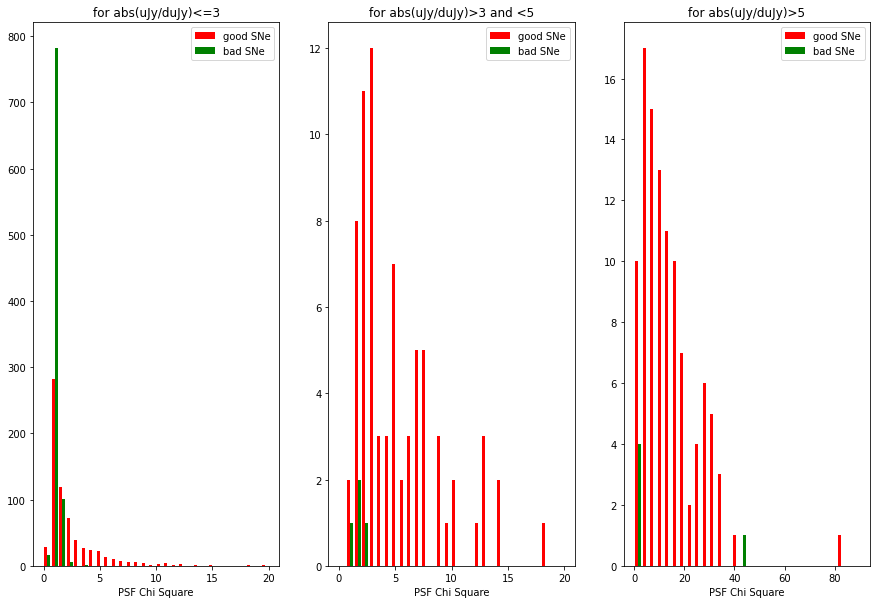

In [4]:
# For each SN, take the measurements for which abs(uJy/duJy)>3 and for which abs(uJy/duJy)<=3.
# Then plot two histograms of those measurements' PSF chi squares on a logarithmic scale. 
# Combine the histograms of each SN and colorcode them. 
# See if each SN's classification is predicted by its chi square distribution on the histograms. 

def get_data(lc_dict,lc_info):
    lc_info = lc_info.reset_index()

    # 3 dfs to store all chi squares corresponding to their uJy/duJy ranges
    leq3_df = pd.Series()
    gr3l5_df = pd.Series()
    gr5_df = pd.Series()

    # for each SN
    for index in range(0,len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]

        leq3 = np.where(abs(lc_dict[index].t['uJy/duJy']) <= 3)[0]
        gr3l5 = AandB(np.where(abs(lc_dict[index].t['uJy/duJy']) > 3)[0], np.where(abs(lc_dict[index].t['uJy/duJy']) < 5)[0])
        gr5 = np.where(abs(lc_dict[index].t['uJy/duJy']) > 5)[0]

        # add chi squares to their corresponding dfs
        leq3_df = pd.concat([leq3_df, lc_dict[index].t.loc[AandB(leq3,baseline),'chi/N']], ignore_index=True)
        gr3l5_df = pd.concat([gr3l5_df, lc_dict[index].t.loc[AandB(gr3l5,baseline),'chi/N']], ignore_index=True)
        gr5_df = pd.concat([gr5_df, lc_dict[index].t.loc[AandB(gr5,baseline),'chi/N']], ignore_index=True)
    
    return leq3_df, gr3l5_df, gr5_df

fig, axes = plt.subplots(nrows=1, ncols=3)
leq3_hist, gr3l5_hist, gr5_hist = axes.flatten()

g_leq3_df, g_gr3l5_df, g_gr5_df = get_data(good_lc,lc_info_good)
b_leq3_df, b_gr3l5_df, b_gr5_df = get_data(bad_lc,lc_info_bad)

leq3_hist.hist([b_leq3_df,g_leq3_df],bins=30,range=(0,20),color=['r','g'], label=['good SNe','bad SNe'])
leq3_hist.set_title("for abs(uJy/duJy)<=3")
leq3_hist.set_xlabel("PSF Chi Square")
leq3_hist.legend()

gr3l5_hist.hist([b_gr3l5_df,g_gr3l5_df],bins=30,range=(0,20),color=['r','g'], label=['good SNe','bad SNe'])
gr3l5_hist.set_title("for abs(uJy/duJy)>3 and <5")
gr3l5_hist.set_xlabel("PSF Chi Square")
gr3l5_hist.legend()

gr5_hist.hist([b_gr5_df,g_gr5_df],bins=30,range=(0,90),color=['r','g'], label=['good SNe','bad SNe'])
gr5_hist.set_title("for abs(uJy/duJy)>5")
gr5_hist.set_xlabel("PSF Chi Square")
gr5_hist.legend()

1030 280


(-10.0, 50.0)

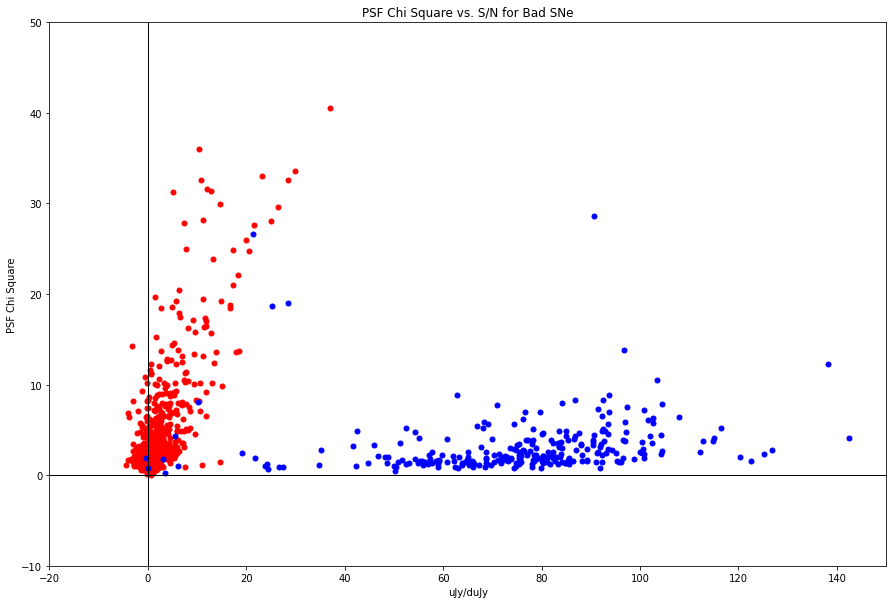

In [5]:
# For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
# See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

"""def plot_data(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        sp, plot, dplot = dataPlot(lc_dict[index].t.loc[baseline,'uJy/duJy'],lc_dict[index].t.loc[baseline,'chi/N'])
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')
    return sp, plot, dplot

sp, plot1, dplot = plot_data(good_lc,lc_info_good)
matlib.setp(plot1,ms=5,color='g',marker='o')
plt.title('PSF Chi Square vs. S/N for Good SNe')
plt.xlim(-5,5)
plt.ylim(-1,3)

sp, plot2, dplot = plot_data(bad_lc,lc_info_bad)
matlib.setp(plot2,ms=5,color='r',marker='o')
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,400)
plt.ylim(-100,6000)"""

def plot_data(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        after_mjdstart = np.where(lc_dict[index].t['MJD'] > lc_info.loc[index,'mjdstart'])[0]
        sp, plot1, dplot = dataPlot(lc_dict[index].t.loc[baseline,'uJy/duJy'],lc_dict[index].t.loc[baseline,'chi/N'])
        matlib.setp(plot1,ms=5,color='r',marker='o')
        sp, plot2, dplot = dataPlot(lc_dict[index].t.loc[after_mjdstart,'uJy/duJy'],lc_dict[index].t.loc[after_mjdstart,'chi/N'])
        matlib.setp(plot2,ms=5,color='b',marker='o')

        print(len(baseline),len(after_mjdstart))
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')

plot_data(bad_lc,lc_info_bad)
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,150)
plt.ylim(-10,50)

(-5.0, 15.0)

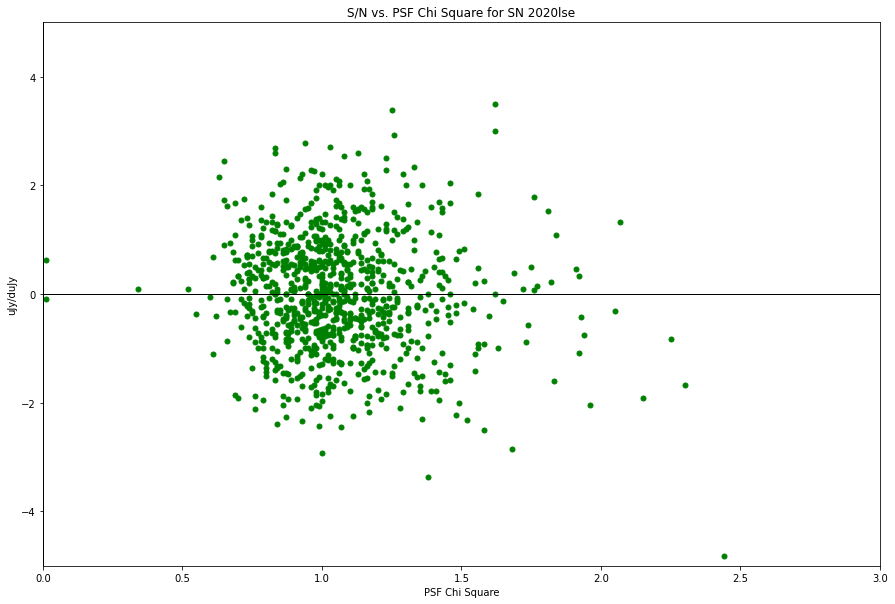

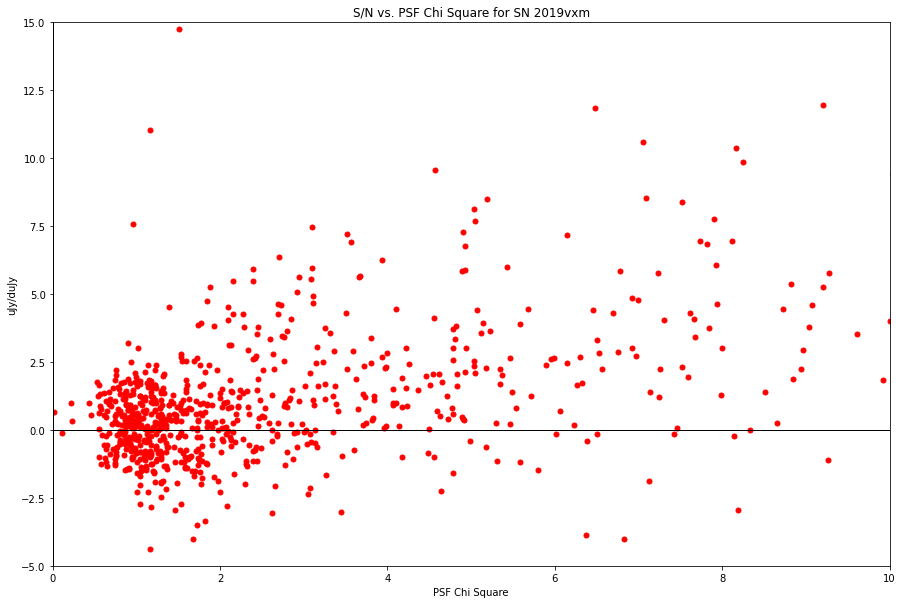

In [6]:
def plot_data2(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        plt.figure()
        sp, plot, dplot = dataPlot(lc_dict[index].t.loc[baseline,'chi/N'],lc_dict[index].t.loc[baseline,'uJy/duJy'])
        plt.axhline(linewidth=1,color='k')
        plt.axvline(linewidth=1,color='k')
        plt.xlabel('PSF Chi Square')
        plt.ylabel('uJy/duJy')
        if lc_info.loc[index,'classification']=='good':
            color = 'g'
        else:
            color = 'r'
        matlib.setp(plot,ms=5,color=color,marker='o')
        plt.title('S/N vs. PSF Chi Square for SN ' + lc_info.loc[index,'tnsname'])
        return sp, plot, dplot

sp, plot1, dplot = plot_data2(good_lc,lc_info_good)
plt.xlim(0,3)
plt.ylim(-5,5)

sp, plot2, dplot = plot_data2(bad_lc,lc_info_bad)
#plt.xlim(0,2000)
#plt.ylim(None,400)
plt.xlim(0,10)
plt.ylim(-5,15)


In [ ]:
# static cut at x2 = 50; get percent before and after mjdstart
# as x2 cut decreases from 50, what percent of measurements are cut before and after mjdstart?
# for baseline: cut at x2 = , and abs(s/n) = 3 (or 5?)
# - what percent of 
# - 
# for after mjdstart: cut at x2 = 10